In [1]:
from moredata.datasets import get_path
from moredata import Converter
import pandas as pd

df = pd.read_csv(get_path("airbnb-berlin"))
df = df.loc[(~df['latitude'].isna()) & (~df['longitude'].isna())]
df.to_json('./data/airbnb-berlin.json', orient='records')

/home/thomas/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,22,36,41,45,46,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
import moredata

data = moredata.models.Data(data_file='./data/airbnb-berlin.json',
                            parser_func=moredata.parser.parse_document,
                            data_type='json')

osm_enricher = moredata.enricher.osm.OSMPlacesConnector(place_name="Berlin, DE", 
                                                  files=["./data/hotel.csv.gz"],
                                                        radius=50, geometry_intersected=True)

data_enriched = osm_enricher.enrich(data)

moredata.utils.write_json_generator_to_json("./data/airbnb-berlin-enriched", data_enriched, 100000)

/tmp/ipykernel_21145/1572303734.py:7: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,79,80,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,148,149,150,152,153,154,155,156,157,158,159,160,161,162,163,164,166,167,168,169,170,171,172,173,174,175,176,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,269,270,272,273,274,275,2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Columns: 535 entries, Unnamed: 0 to apartment:rental
dtypes: object(535)
memory usage: 0.0+ bytes
None


KeyError: nan

In [1]:
import pandas as pd
df_enriched = pd.read_json('./data/airbnb-berlin-enriched-0.json', orient='records')

In [24]:
df_enriched.loc[(~df_enriched['local'].isna()) & (~df_enriched['geometry_intersected'].isna()), 'near_shop_mall'] = 'Yes'
df_enriched['near_shop_mall'] = df_enriched['near_shop_mall'].fillna('No')

In [25]:
df_enriched['price'] = df_enriched['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))

In [26]:
df_enriched['price'].describe()

count    19858.000000
mean        70.776866
std        120.384857
min          0.000000
25%         35.000000
50%         50.000000
75%         80.000000
max       8000.000000
Name: price, dtype: float64

<AxesSubplot:xlabel='near_shop_mall', ylabel='price'>

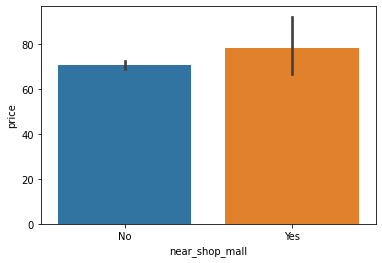

In [33]:
import seaborn as sns
sns.barplot(y="price", x="near_shop_mall", data=df_enriched)

In [35]:
import folium
from moredata.utils import geodesic_point_buffer
from shapely.geometry.polygon import Polygon
import geopandas as gpd
from util import add_categorical_legend

poi = df_enriched.loc[(~df_enriched['geometry_intersected'].isna())][['geometry_intersected', 'latitude', 'longitude']] \
                    .reset_index().iloc[[0]]

polygon = wkt.loads(poi['geometry_intersected'][0][0])
latitude = poi['latitude'].squeeze()
longitude = poi['longitude'].squeeze()

shp = Polygon(geodesic_point_buffer(latitude, longitude, 50))

m = folium.Map(location=[latitude, longitude], zoom_start=17, tiles='CartoDB positron')
folium.Marker(
    [latitude, longitude], icon=folium.Icon(color="blue"), popup='Point of Interest'
).add_to(m)

sim_geo = gpd.GeoSeries.from_wkt([shp.wkt])
geo_j = sim_geo.to_json()

geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'grey'})
geo_j.add_to(m)
    
sim_geo = gpd.GeoSeries(polygon)
geo_j = sim_geo.to_json()

geo_j = folium.GeoJson(data=geo_j,
                       style_function=lambda x: {'fillColor': 'black', 'color': 'black'})
geo_j.add_to(m)

m = add_categorical_legend(m, 'Polygons',
                             colors = ['blue','black'],
                           labels = ['Point of Interest', 'Shopping Mall'])

m